In [1]:
# Standard librares
import numpy as np
from numpy import pi
from scipy.constants import epsilon_0, mu_0
from scipy.special import jv, jvp, hankel2, h2vp
from matplotlib import pyplot as plt
from scipy.sparse import dia_matrix
from scipy.linalg import norm
from numpy import random as rnd

# Transform cartesian coordinates into polar ones
def cart2polar(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    phi[phi<0] = 2*pi + phi[phi<0]
    return rho, phi

# The Multi-Objective EIS Problem

The Electromagnetic Inverse Scattering (EIS) problem has been considered in the literature as a mono-objective one throughout the years. However, in many formulations, the objective function is written in terms of a weighted sum, which is a common approach to multi-objective problems. In this case, the objective functions are addressed together and the optimization problem is converted to a mono-objective one.

The multi-objective approaches are considered when two or more objectives are conflicting, i.e., where there is a trade-off between the objectives. In these cases, we might convert the problem into a mono-objective one through the weighted sum; we might turn all objective functions (excepting one) into constraints and solve the mono-objective problem for the remaining function ($\epsilon$-constrainted); or we might address all objectives together in order to obtain not one but a set of solutions called **Pareto Set of Solutions**. This set are solutions which are incomparable among themselves, i.e., we can not decide which one is the best or worse since each one represents a trade-off among the objectives. Fortunatelly, there are efficient algorithms for this kind of optimization problem.

In EIS problems, we are commonly dealing with the minimization of the residuals of the data and state equations. Futhermore, regularization terms are usually added in order to address the ill-posedness of problem, such as the Tikhnov and the Total Variation functionals. Most of the methods proposed in the literature address the weighted sum of these functionals and it has not been found references for a multi-objective approach.

Therefore, we will run a single demonstration of a basic multi-objective methodology considering the following functionals:

$$ \min f_0(\chi, E_{z}) = \sum_{m=1}^M |E_{z,m}^s + \sum_{n=1}^N h_{mn}\chi_nE_{z,n}|^2 \\
\min f_1(\chi, E_{z}) = ||\chi||^2 $$

In [2]:
def feval(X, Ez, HD, HS, Esz, Eiz):
    f0 = np.sum(np.abs(Esz + HD @ X @ Ez)**2)
    f1 = norm(X.diagonal(0))**2
    return f0, f1

## The Multi-Objective Particle Swarm Optimization

The Particle Swarm Optimization (PSO) algorithm is a commonly applied to the EIS problem. However, when we apply it into a multi-objective problem, it is necessary to adapt the structure of personal and global solutions. Instead of storing a single global solution, we are going to store a set, called *Archive*. In this set we are going to store all the *non-dominated* individuals found by the algorithm, i.e., the solutions which can not be compared among themselves but are better in both objectives in respect to all others found by the algorithm.

The way in which the Archive is updated is an important aspect of the algorithm. Considering an arbitraty solution, it will be added into the Archive in this implementation if one of the following rules may apply:

1. If the Archive is empty;
2. If it dominates one or more solutions in the Archive, then it will replace all the dominated solutions;
3. If it is not dominated by any of the solutions in the Archive and:
  1. If the Archive is not full, the solution is added;
  2. The solution is added if its evaluation of Tikhonov function is greater than the minimum one in the Archive and lesser than the maximum one. The solution with the minimum value in the Archive is removed.

In [3]:
def update_archive(PX, PE, fx, gxbest, gebest, fx_gbest, MAX_ARCHIVE):
    """Update the archive given a population of solutions."""

    N = len(gxbest)  # Current size of Archive

    # If the Archive is empty, the first solution is added
    if N == 0:
        gxbest.append(PX[0, :].copy())
        gebest.append(PE[0, :].copy())
        fx_gbest.append(fx[0, :].copy())
        i0 = 1
    else:
        i0 = 0

    # For each solution in the population 
    for i in range(i0, PX.shape[0]):

        # Compare the solution to the ones in the Archive
        dominated_solutions, nondominated_solution = compare2archive(fx[i, :], fx_gbest)

        # The solution is dominated by any solution in the Archive, skip to the next
        if not nondominated_solution:
            continue

        # If the solution dominates one or more solutions in the Archive
        elif len(dominated_solutions) > 0:

            # Remove the dominated solutions
            for j in range(len(dominated_solutions)-1, -1, -1):
                gxbest.pop(dominated_solutions[j])
                gebest.pop(dominated_solutions[j])
                fx_gbest.pop(dominated_solutions[j])

            # Add the new one
            gxbest.append(PX[i, :].copy())
            gebest.append(PE[i, :].copy())
            fx_gbest.append(fx[i, :].copy())

        # If it does not dominate nor is dominated and the Archive is not full, add it
        elif len(gxbest) < MAX_ARCHIVE:
            gxbest.append(PX[i, :].copy())
            gebest.append(PE[i, :].copy())
            fx_gbest.append(fx[i, :].copy())

        # Otherwise...
        else:

            # Look for the minimum and maximum values of Tikhonov functional in the Archive
            min_fx1, jmin = fx_gbest[0][1], 0
            max_fx1, jmax = fx_gbest[0][1], 0
            for j in range(1, len(fx_gbest)):
                if min_fx1 > fx_gbest[j][1]:
                    jmin, min_fx1 = j, fx_gbest[j][1]
                elif max_fx1 < fx_gbest[j][1]:
                    jmax, max_fx1 = j, fx_gbest[j][1]

            if fx[i, 1] > min_fx1 and fx[i, 1] < max_fx1:

                # Remove extreme solution
                gxbest.pop(jmin)
                gebest.pop(jmin)
                fx_gbest.pop(jmin)
            
                # Add the new one
                gxbest.append(PX[i, :].copy())
                gebest.append(PE[i, :].copy())
                fx_gbest.append(fx[i, :].copy())

    # Keep the archive sorted
    gxbest, gebest, fx_gbest = sort_archive(gxbest, gebest, fx_gbest)
    return gxbest, gebest, fx_gbest

def compare2archive(fx0, fx):
    """Determine if a solution dominates or is dominated by the solutions in the Archive."""
    dominated_solutions = []
    nondominated_solution = True
    for i in range(len(fx)):

        # It dominates
        if fx0[0] <= fx[i][0] and fx0[1] <= fx[i][1]:
            dominated_solutions.append(i)

        # It is dominated
        elif fx0[0] >= fx[i][0] and fx0[1] >= fx[i][1]:
            nondominated_solution = False
            break

    return dominated_solutions, nondominated_solution

def sort_archive(PX, PE, fx):
    """Sort the archive."""
    array = []
    for i in range(len(fx)):
        array.append(fx[i][0])
    idx = np.argsort(array)
    new_px, new_pe, new_fx = [], [], []
    for i in range(len(fx)):
        new_px.append(PX[idx[i]])
        new_pe.append(PE[idx[i]])
        new_fx.append(fx[idx[i]])
    return new_px, new_pe, new_fx

def crowding_distance(fx_gbest):
    """Crowding Distance measure."""
    M = len(fx_gbest)
    dist = np.zeros(M)
    fx = np.zeros((2, M))
    for m in range(M):
        fx[0, m] = fx_gbest[m][0]
        fx[1, m] = fx_gbest[m][1]
    idx = np.argsort(fx[0, :])
    dist[idx[0]] = np.inf
    dist[idx[-1]] = np.inf
    for m in range(1, M-1):
        dist[idx[m]] += (fx[0, idx[m+1]]-fx[0, idx[m-1]])/(fx[0, idx[-1]]-fx[0, idx[0]])
    idx = np.argsort(fx[1, :])
    for m in range(1, M-1):
        dist[idx[m]] += (fx[1, idx[m+1]]-fx[1, idx[m-1]])/(fx[1, idx[-1]]-fx[1, idx[0]])
    return dist

## Scattering of a circular cylinder

The scattering problem considered in this demonstration is a simple one: the scattering of a circular cylinder when a single plane incident wave is present. This is a problem with an analytic solution. The following paraterms for the problem are considered:

* Radius of the circle ($a$): $0.25\lambda$;
* Relative permittivity of the object ($\epsilon_{rd}$): $2.0$;
* Radius of observation ($R_O$): $2\lambda$;
* Number of measurements ($M$): $10$;
* Resolution of the recovered image: $10\times10$.

In [4]:
# Parameters
lambdab = 1.0  # [1/m]
a = 0.25*lambdab
epsilon_rd = 2.0
Ro = 2*lambdab
M = 10
resolution = (10, 10)

# Constants
E0 = 1.0  # [V/m]
kb = 2*pi/lambdab
f = 1/np.sqrt(epsilon_0*mu_0)/lambdab
omega = 2*pi*f
Lx, Ly = lambdab, lambdab
kd = omega*np.sqrt(epsilon_rd*epsilon_0*mu_0)
lamdad = 2*pi/kd
epsilon_d = epsilon_rd*epsilon_0

# Computing scattered field
NT = 100
n = np.arange(-NT, NT+1, dtype=float)
an = -jv(n, kb*a)/hankel2(n, kb*a) * (epsilon_d*jvp(n, kd*a)/(epsilon_0*kd*a*jv(n, kd*a)) - jvp(n, kb*a)/(kb*a*jv(n, kb*a))) / (epsilon_d*jvp(n, kd*a)/(epsilon_0*kd*a*jv(n, kd*a)) - h2vp(n, kb*a)/(kb*a*hankel2(n, kb*a)))
phi = np.linspace(0, 2*pi, M, endpoint=False)
Esz = np.zeros(phi.size, dtype=complex)
for i in range(M):
    Esz[i] = E0*np.sum(1j**(-n)*an*hankel2(n, kb*Ro)*np.exp(1j*n*phi[i]))
xm, ym = Ro*np.cos(phi), Ro*np.sin(phi)

# Computing the incident field
N = resolution[0]*resolution[1]
dy, dx = Ly/resolution[0], Lx/resolution[1]
x, y = np.meshgrid(np.arange(-Lx/2 + dx/2, Lx/2, dx), np.arange(-Ly/2 + dy/2, Ly/2, dy))
rho, phi = cart2polar(x, y)
Eiz = E0*np.exp(1j*kb*rho*np.cos(phi)).flatten()
cell_area = np.sqrt(dx*dy/pi)

# Data equation
HD = np.zeros((M, N), dtype=complex)
for m in range(M):
    R = np.sqrt((x-xm[m])**2 + (y-ym[m])**2).flatten()
    HD[m, :] = 1j*pi*kb*cell_area/2*jv(1, kb*cell_area)*hankel2(0, kb*R)

# State Equation
HS = np.zeros((N, N), dtype=complex)
for k in range(N):
    i, j = np.unravel_index(k, resolution)
    R = np.sqrt((x-x[i, j])**2 + (y-y[i, j])**2).flatten()
    HS[k, :] = 1j*pi*kb*cell_area/2*jv(1, kb*cell_area)*hankel2(0, kb*R)
    HS[k, R==0] = 1j/2*(pi*kb*cell_area*hankel2(1, kb*cell_area)-2j)

## MOPSO parameters

The following parameters for the MOPSO algorithm will be considered:

* Number of particles ($N_{PAR}$): 250;
* Inertia weight ($w$): 0.4;
* Acceleration coefficients ($c_1$, $c_2$): 2.0;
* Maximum number of solutions in the Archive: 20;
* Number of iterations: 20,000;

In [5]:
NPAR = 250
w = .4
c1 = c2 = 2.0
MAX_ARCHIVE = 20
NITER = 20000

## Initialization

The particles will be initialized with random values. For contrast values ($\chi$), we wil consider random values from a uniform distribution between 0 and 1; for electric field values, we will consider a standard normal distribution for real and imaginary parts. The velocity values will be zero in the first iteration.

In [6]:
NVAR = resolution[0]*resolution[1]  # Number of variables

PX = rnd.rand(NPAR, NVAR)  # array of contrast particles
PE = rnd.normal(size=(NPAR, NVAR)) + 1j*rnd.normal(size=(NPAR, NVAR))  # array of electric field particles
vx = np.zeros((NPAR, NVAR), dtype=complex)  # array of contrast velocities
ve = np.zeros((NPAR, NVAR), dtype=complex)  # array of electric field velocities
fx = np.zeros((NPAR, 2))  # evaluation of each particle

# Evaluate particles
for i in range(NPAR):
    X = dia_matrix((PX[i, :].flatten(), 0), shape=(N, N))
    Ez = PE[i, :].flatten()
    fx[i, 0], fx[i, 1] = feval(X, Ez, HD, HS, Esz, Eiz)

# Personal best particles
pxbest = np.zeros((NPAR, NVAR), dtype=complex)
pebest = np.zeros((NPAR, NVAR), dtype=complex)
fx_pbest = np.inf*np.ones(fx.shape) 

# Archive - Global best particles
gxbest = []
gebest = []
fx_gbest = []

## Running the algorithm

When we implement the MOPSO algorithm, there are two common questions: (i) how do we update the personal best particles? (ii) How do we choose archive solutions for velocity update? There are many ways to implemment it and a lot of strategies. For the sake of simplicity, we are addressing the following rules:

* We will update the personal best particle any time we obtain a new non-dominated solution;
* We will choose randomly a single solution from the Archive to update each velocity array.

In [7]:
for it in range(NITER):

    # Update pbest
    for n in range(NPAR):

        # If it the new particle is a new non-dominated one
        if not(fx[n, 0] >= fx_pbest[n, 0] and fx[n, 1] >= fx_pbest[n, 1]):
            pxbest[n, :] = PX[n, :]
            pebest[n, :] = PE[n, :]
            fx_pbest[n, :] = fx[n, :]

    # Update Archive
    gxbest, gebest, fx_gbest = update_archive(PX, PE, fx, gxbest, gebest, fx_gbest, MAX_ARCHIVE)

    # Calculate particle velocity
    idx = rnd.randint(len(fx_gbest), size=NPAR)  # Random choice of solutions in the Archive
    for n in range(NPAR):
        vx[n, :] = w*vx[n, :] + c1*rnd.rand(1, NVAR)*(pxbest[n, :]-PX[n, :]) + c2*rnd.rand(1, NVAR)*(gxbest[idx[n]]-PX[n, :])
        ve[n, :] = w*ve[n, :] + c1*rnd.rand(1, NVAR)*(pebest[n, :]-PE[n, :]) + c2*rnd.rand(1, NVAR)*(gebest[idx[n]]-PE[n, :])

    # Update particle position
    PX = PX + vx
    PE = PE + ve

    # Boundary condition for contrast
    PX[PX < 0] = 0

    # Update particle evalution
    for i in range(NPAR):
        X = dia_matrix((PX[i, :].flatten(), 0), shape=(N, N))
        Ez = PE[i, :].flatten()
        fx[i, 0], fx[i, 1] = feval(X, Ez, HD, HS, Esz, Eiz)  # Evaluate particles

    if it == 0:
        print('Iterations: 1/%d' % NITER + ' - Length of Archive: %d' % len(fx_gbest))
    elif it == NITER-1:
        print('Iterations: %d/' % NITER + '%d' % NITER + ' - Length of Archive: %d' % len(fx_gbest))
    elif NITER == 10 or (it+1) % (NITER/10) == 0:
        print('Iterations: %d/' % (it+1) + '%d' % NITER + ' - Length of Archive: %d' % len(fx_gbest))

Iterations: 1/20000 - Length of Archive: 8
Iterations: 2000/20000 - Length of Archive: 20
Iterations: 4000/20000 - Length of Archive: 20
Iterations: 6000/20000 - Length of Archive: 20
Iterations: 8000/20000 - Length of Archive: 20
Iterations: 10000/20000 - Length of Archive: 20
Iterations: 12000/20000 - Length of Archive: 18
Iterations: 14000/20000 - Length of Archive: 13
Iterations: 16000/20000 - Length of Archive: 13
Iterations: 18000/20000 - Length of Archive: 13
Iterations: 20000/20000 - Length of Archive: 13


The final Pareto set of solutions had a smaller size then the maximum one. Considering that in the last 6,000 iterations the size did not changed, it is possible that the Pareto set did not change, i.e., a large number of iterations without any new non-dominated solution. It is also possible that solutions could be exchanged one by one.

## Results

The Pareto Frontier obtained at the end of the algorithm is shown below:

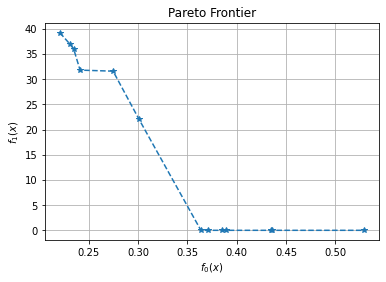

In [8]:
pareto = np.zeros((2, len(fx_gbest)))

for i in range(len(fx_gbest)):
    pareto[0, i] = fx_gbest[i][0]
    pareto[1, i] = fx_gbest[i][1]

plt.plot(pareto[0, :], pareto[1, :], '--*')
plt.xlabel(r'$f_0(x)$')
plt.ylabel(r'$f_1(x)$')
plt.title('Pareto Frontier')
plt.grid()
plt.show()

And the contrast map of each solution in the Pareto Frontier is:

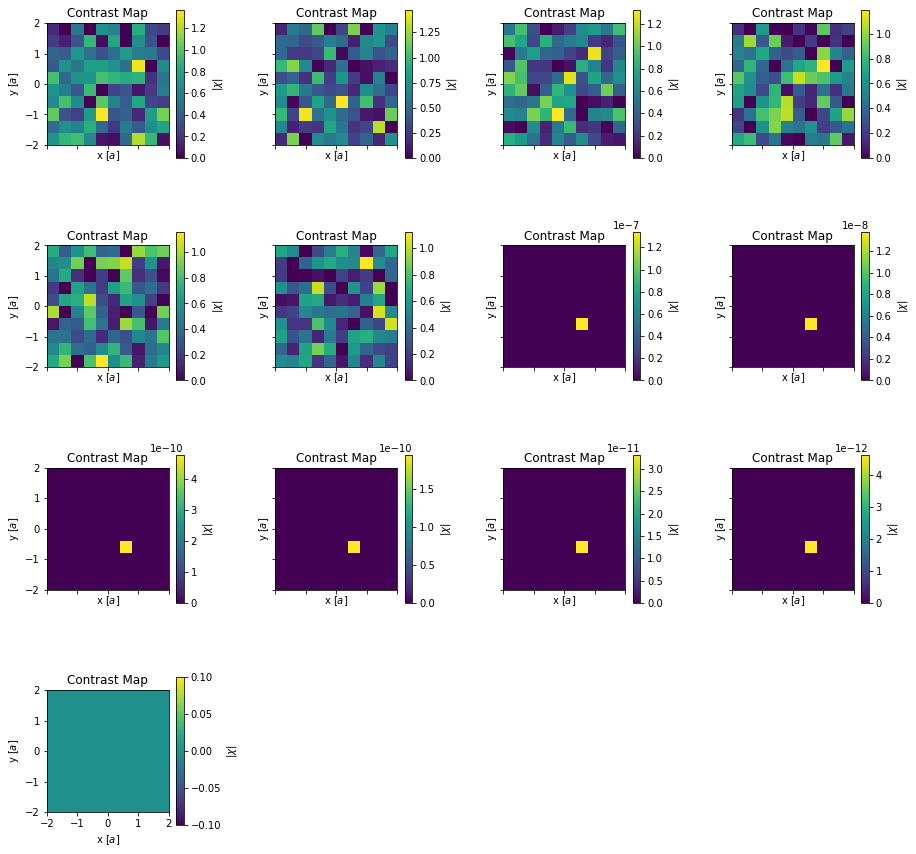

In [9]:
nrows = int(np.ceil(np.sqrt(len(gxbest))))
ncols = int(np.ceil((len(gxbest)/nrows)))

fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15), sharey=True, sharex=True)
fig.subplots_adjust(hspace=.5, wspace=.5)
axis = axis.flatten()

for i in range(axis.size):

    if i < len(gxbest):

        sb1 = axis[i].imshow(np.abs(gxbest[i].reshape(resolution)), extent=[-2, 2, -2, 2], origin='lower')
        axis[i].set_xlabel(r'x [$a$]')
        axis[i].set_ylabel(r'y [$a$]')
        axis[i].set_title('Contrast Map')
        cbar1 = fig.colorbar(sb1, ax=axis[i])
        cbar1.set_label(r'$|\chi|$')

    else:
        axis[i].set_visible(False)

plt.show()

Even with the change of the rule for the exchange of solutions in the full archive, the optimal solution for the Tikhonov solution was still stored and kept in the archive. This may suggest that this solution was found when in archive was not full and its size was kept smaller than the maximum for the rest of the iterations. Otherwise any other non-dominated solution would remove this one if the archive was full.

## Conclusions

This result with the others seems to suggest that, independent from the design of the objective function, this kind of problem seems to be too hard to be solved with this kind of representation of solution.